In [1]:
import sys
sys.path.append('../')
import chcochleagram
import torch as ch
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

# Set cochleagram parameters and build the cochleagram operation

The steps of the cochleagram operations are outlined below for an example cochleagram. 

### Define the cochlear filters

Text(0, 0.5, 'Filter Magnitude')

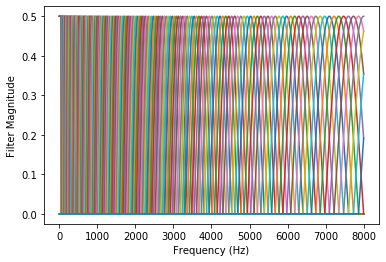

In [27]:
### Args used for multiple stages of the cochleagram operations
signal_size = 32000 # Length of the input audio signal (currently must be fixed, due to filter construction)
sr = 16000 # Sampling rate of the input audio
pad_factor = 1.25 # Zero padding applied to the waveform, so the end signal is length pad_factor*signal_length
use_rfft = True # Whether to use rfft operations when appropriate (recommended)

### Define the cochlear filters using ERBCosFilters. 
# These are the arguments used for filter construction of ERBCosFilters. See helpers/erb_filters.py for 
# more documentation. 
half_cos_filter_kwargs = {
    'n':50, # Number of filters to evenly tile the space
    'low_lim':50, # Lowest center frequency for full filter (if lowpass filters are used they can be centered lower)
    'high_lim':8000, # Highest center frequency 
    'sample_factor':4, # Positive integer that determines how densely ERB function will be sampled
    'full_filter':False, # Whether to use the full-filter. Must be False if rFFT is true. 
}
# These arguments are for the CochFilters class (generic to any filters). 
coch_filter_kwargs = {'use_rfft':use_rfft,
                      'pad_factor':pad_factor,
                      'filter_kwargs':half_cos_filter_kwargs}

# This (and most) cochleagrams use ERBCosFilters, however other types of filterbanks can be 
# constructed for linear spaced filters or different shapes. Make a new CochlearFilter class for 
# these. 
filters = chcochleagram.cochlear_filters.ERBCosFilters(signal_size,
                                                       sr, 
                                                       **coch_filter_kwargs)

### Look at the filters 
# Filters are in form [filter_idx, frequency, (real_value, complex_value)] where for ERB filters 
# the complex component is 0. Newer versions of pytorch have complex types, but complex values are 
# represented with an extra dimension for now. 
for f_idx in range(filters.coch_filters.shape[0]):
    plt.plot(filters.filter_extras['freqs'], filters.coch_filters[f_idx,:,0]) 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter Magnitude')

### Define the other cochleagram components. 
* Envelope extraction
* Downsampling operation
* Compression applied to the envelopes

In [31]:
### Define an envelope extraction operation
# Use the analytic amplitude of the hilbert transform here. Other types of envelope extraction 
# are also implemented in envelope_extraction.py. Can use Identity if want the raw subbands. 
envelope_extraction = chcochleagram.envelope_extraction.HilbertEnvelopeExtraction(signal_size,
                                                                                  sr, 
                                                                                  use_rfft, 
                                                                                  pad_factor)

### Define a downsampling operation
# Downsample the extracted envelopes. Can use Identity if want the raw subbands. 
env_sr = 200 # Sampling rate after downsampling
downsampling_kwargs = {'window_size':1001} # Parameters for the downsampling filter (see downsampling.py)
downsampling_op = chcochleagram.downsampling.SincWithKaiserWindow(sr, env_sr, **downsampling_kwargs)

### Define a compression operation.
compression_kwargs = {'power':0.3, # Power compression of 0.3 
                      'offset':1e-8, # Offset for numerical stability in backwards pass
                      'scale':1, # Optional multiplicative value applied to the envelopes before compression 
                      'clip_value':100} # Clip the gradients for this compression for stability
compression = chcochleagram.compression.ClippedGradPowerCompression(**compression_kwargs)

### Once the operations are defined, put them all together into the Cochleagram module. 

In [32]:
cochleagram = chcochleagram.cochleagram.Cochleagram(filters, 
                                                    envelope_extraction,
                                                    downsampling_op,
                                                    compression=compression)

# Make an example signal and calculate its cochleagram

Text(0, 0.5, 'Frequency (Hz)')

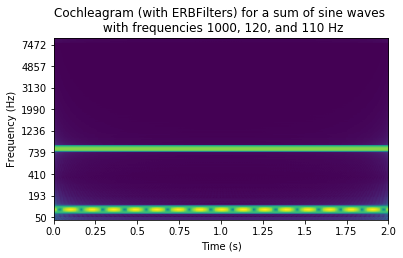

In [114]:
# Build x as a sum of a few sine waves. 
freq = 1000
time_x = np.arange(0, signal_size)/20000;
# Amplitude of the sine wave is sine of a variable like time
amplitude = np.sin(2 * np.pi * freq * time_x)

# These two frequencies will show some beating in the cochleagram. 
freq2 = 120
amplitude += np.sin(2 * np.pi * freq2 * time_x)
freq3 = 110
amplitude += np.sin(2 * np.pi * freq3 * time_x)

# Add batch dimension. 
amplitude = np.expand_dims(amplitude, 0)

# Convert to pytorch tensor. 
x = ch.autograd.Variable(ch.Tensor(amplitude), requires_grad=True)

# Make the cochleagram
y = cochleagram(x)

# Plot the cochleagram
plt.imshow(np.squeeze(y.detach().numpy()), origin='lower', extent=(0, y.shape[2], 0, y.shape[1]))

plt.title('Cochleagram (with ERBFilters) for a sum of sine waves \n with frequencies %d, %d, and %d Hz'%(freq, freq2, freq3))

## Depending on the temporal padding the cochleagram length may not be exactly equal env_sr*signal_size/sr
# Because of this, set the x-axis tick labels based on the original audio. 
num_ticks = 9
x_tick_numbers = [t_num*y.shape[-1]/(num_ticks-1) for t_num in range(num_ticks)]
x_tick_labels = [t_num*signal_size/sr/(num_ticks-1) for t_num in range(num_ticks)]
plt.xticks(x_tick_numbers, x_tick_labels)
plt.xlabel('Time (s)')

## Label the frequency axis based on the center frequencies for the ERB filters. 
filters.filter_extras['cf']
# Use ticks starting at the lowest non-lowpass filter center frequency. 
y_ticks = [y_t+3 for y_t in plt.yticks()[0] if y_t<=y.shape[1]]
plt.yticks(y_ticks, [int(round(filters.filter_extras['cf'][int(f_num)])) for f_num in y_ticks])
plt.ylabel('Frequency (Hz)')